<a href="https://colab.research.google.com/github/Cimbir/Store-Sales-Forecasting/blob/main/model_patchtst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 106.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
!pip install neuralforecast datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 629MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [6]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
import pickle
import seaborn as sns
import random
import math

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from neuralforecast.models import PatchTST
from neuralforecast.core import NeuralForecast
from datasetsforecast.long_horizon import LongHorizon

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
import warnings
warnings.filterwarnings('ignore')

# Evaluate

In [8]:
def WMAE(preds_combined):
    weights = preds_combined['IsHoliday_x'].apply(lambda x: 5 if x else 1)
    return (np.sum(weights * abs(preds_combined['y'].values - preds_combined['PatchTST'].values)) / np.sum(weights))

In [9]:
class WeightedMAELoss(nn.Module):
    def __init__(self):
        super(WeightedMAELoss, self).__init__()

    def forward(self, y_pred, y_true, holidays):
      weights = torch.where(holidays == 1, torch.tensor(5.0).to(holidays.device), torch.tensor(1.0).to(holidays.device))
      mae = torch.abs(y_pred - y_true)
      return (weights * mae).mean()

In [10]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_pred, y_true, holidays):
      weights = torch.where(holidays == 1, torch.tensor(5.0).to(holidays.device), torch.tensor(1.0).to(holidays.device))
      mse = (y_pred - y_true) ** 2
      return (weights * mse).mean()

# Get Data

In [11]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

test_df = pd.read_csv('test.csv')

In [12]:
df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.drop('IsHoliday_y', axis=1)

df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Unique stores: {df['Store'].nunique()}")
print(f"Unique departments: {df['Dept'].nunique()}")

test_df['Date'] = pd.to_datetime(test_df['Date'])

print(f"Test dataset shape: {test_df.shape}")
print(f"Test date range: {test_df['Date'].min()} to {test_df['Date'].max()}")

display(df.head())

Dataset shape: (421570, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Unique stores: 45
Unique departments: 81
Test dataset shape: (115064, 4)
Test date range: 2012-11-02 00:00:00 to 2013-07-26 00:00:00


Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

# Visualize data

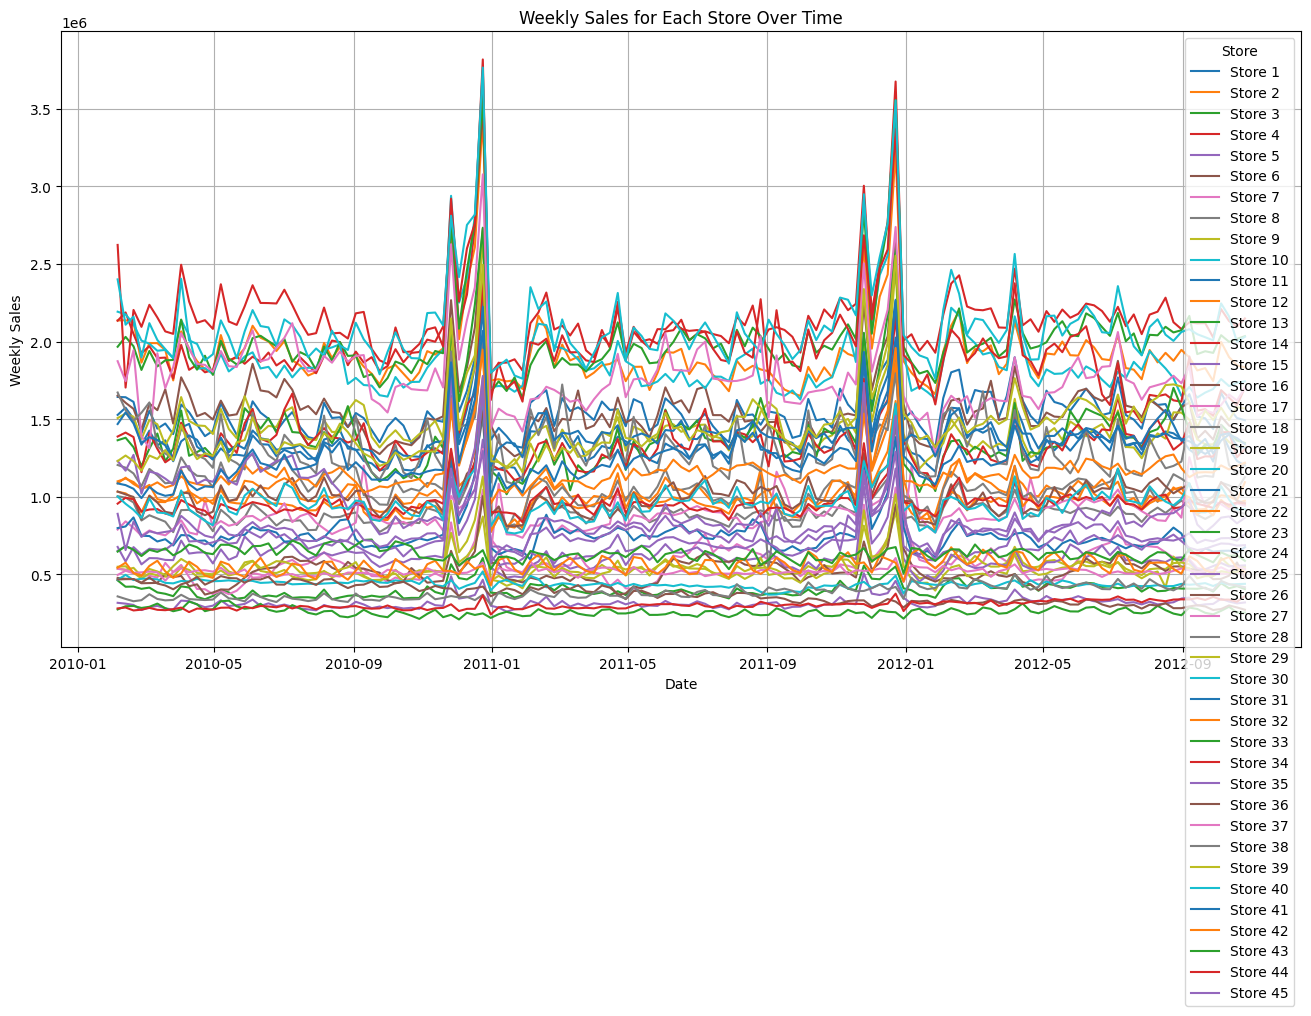

In [ ]:
# Group by Store and Date to get weekly sales for each store
weekly_sales_by_store = df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Stores as columns and Dates as index
weekly_sales_pivot = weekly_sales_by_store.pivot(index='Date', columns='Store', values='Weekly_Sales')

# Plot the weekly sales for each store
plt.figure(figsize=(16, 8))
for store in weekly_sales_pivot.columns:
    plt.plot(weekly_sales_pivot.index, weekly_sales_pivot[store], label=f'Store {store}')

plt.title('Weekly Sales for Each Store Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Store')
plt.grid(True)
plt.show()

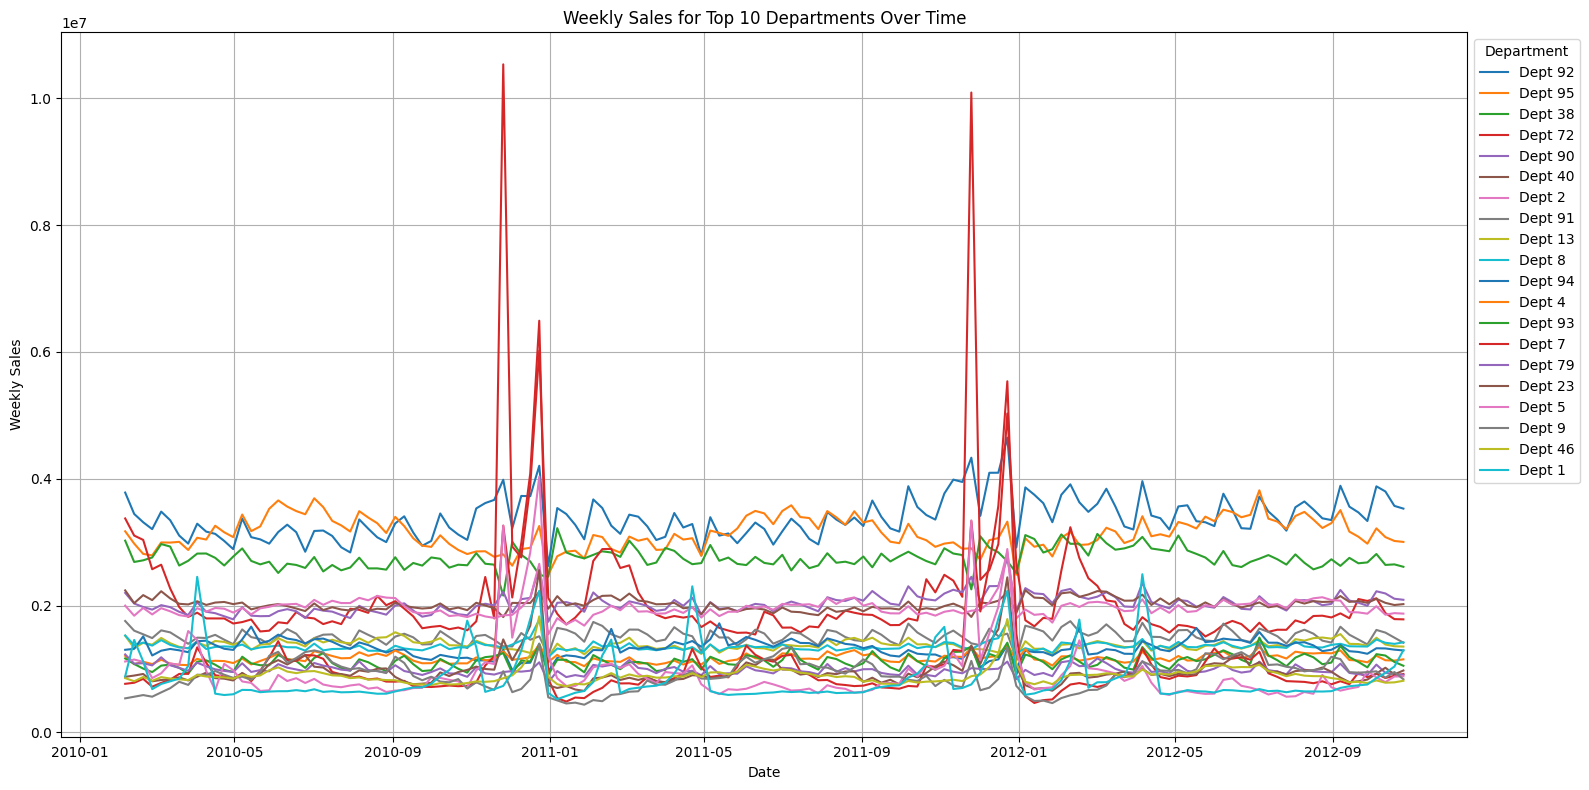

In [ ]:
# Group by Department and Date to get weekly sales for each department
weekly_sales_by_dept = df.groupby(['Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Departments as columns and Dates as index
weekly_sales_pivot_dept = weekly_sales_by_dept.pivot(index='Date', columns='Dept', values='Weekly_Sales')

# Plot the weekly sales for each department (plotting too many lines might be cluttered)
# Let's plot sales for a few departments as an example
plt.figure(figsize=(16, 8))
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(20).index

for dept in top_depts:
    if dept in weekly_sales_pivot_dept.columns:
        plt.plot(weekly_sales_pivot_dept.index, weekly_sales_pivot_dept[dept], label=f'Dept {dept}')

plt.title('Weekly Sales for Top 10 Departments Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Department', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

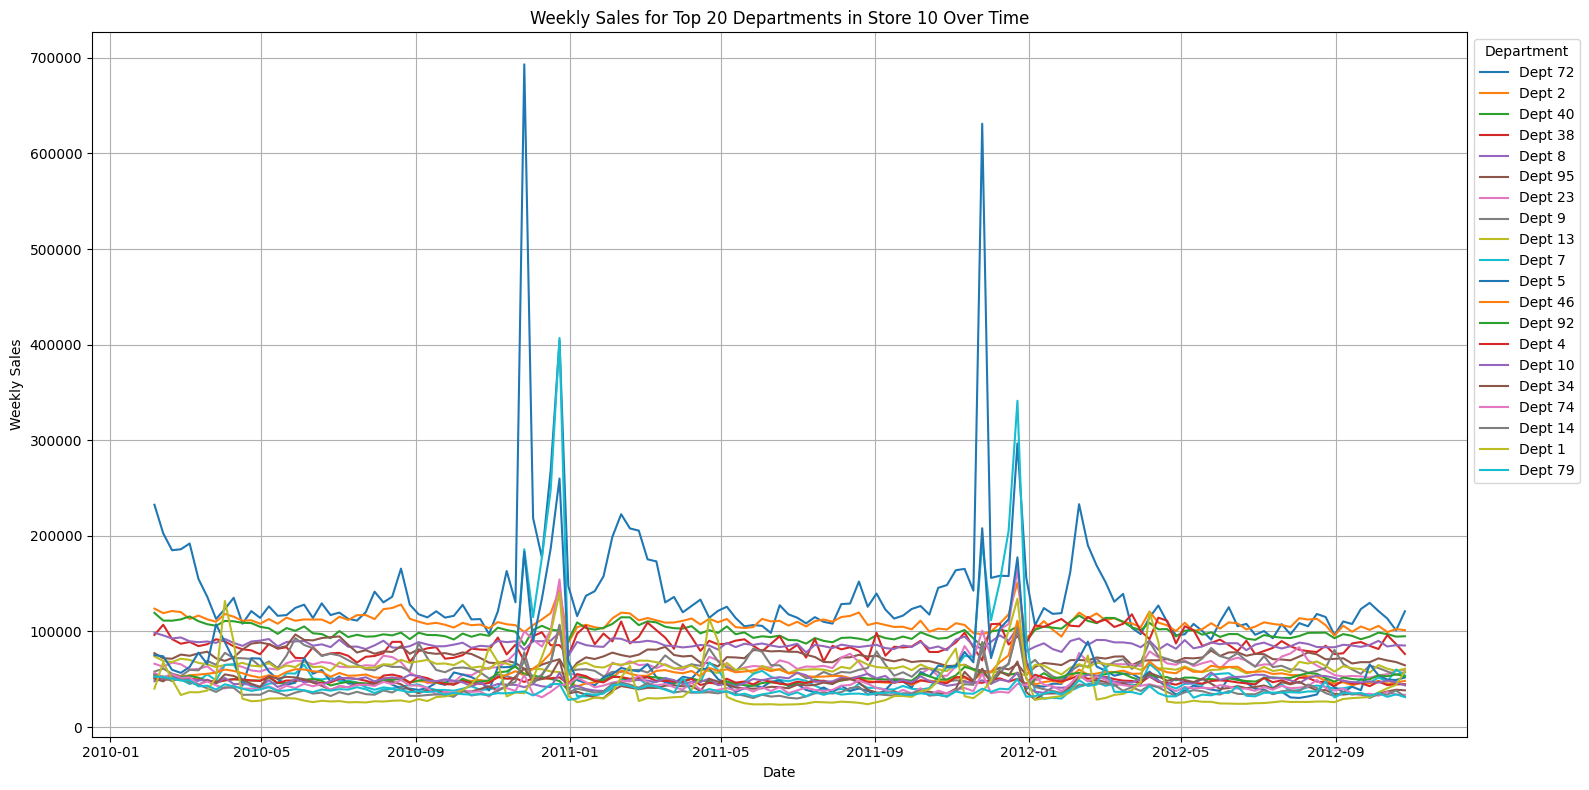

In [ ]:
# Choose a store ID
store_id = 10  # You can change this to the store you are interested in

# Filter data for the selected store
store_df = df[df['Store'] == store_id].copy()

# Group by Department and Date to get weekly sales for each department in the selected store
weekly_sales_by_dept_store = store_df.groupby(['Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Departments as columns and Dates as index
weekly_sales_pivot_dept_store = weekly_sales_by_dept_store.pivot(index='Date', columns='Dept', values='Weekly_Sales').fillna(0)

# Get the total sales for each department across all weeks for this store to find the top 20 departments
department_total_sales = weekly_sales_pivot_dept_store.sum().sort_values(ascending=False)

# Select the top 20 departments for this store
top_20_depts_store = department_total_sales.head(20).index

# Filter the pivoted data to include only the top 20 departments
weekly_sales_pivot_dept_store_top20 = weekly_sales_pivot_dept_store[top_20_depts_store]

# Plot the weekly sales for the top 20 departments in the selected store
plt.figure(figsize=(16, 8))

for dept in weekly_sales_pivot_dept_store_top20.columns:
    plt.plot(weekly_sales_pivot_dept_store_top20.index, weekly_sales_pivot_dept_store_top20[dept], label=f'Dept {dept}')

plt.title(f'Weekly Sales for Top 20 Departments in Store {store_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Department', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

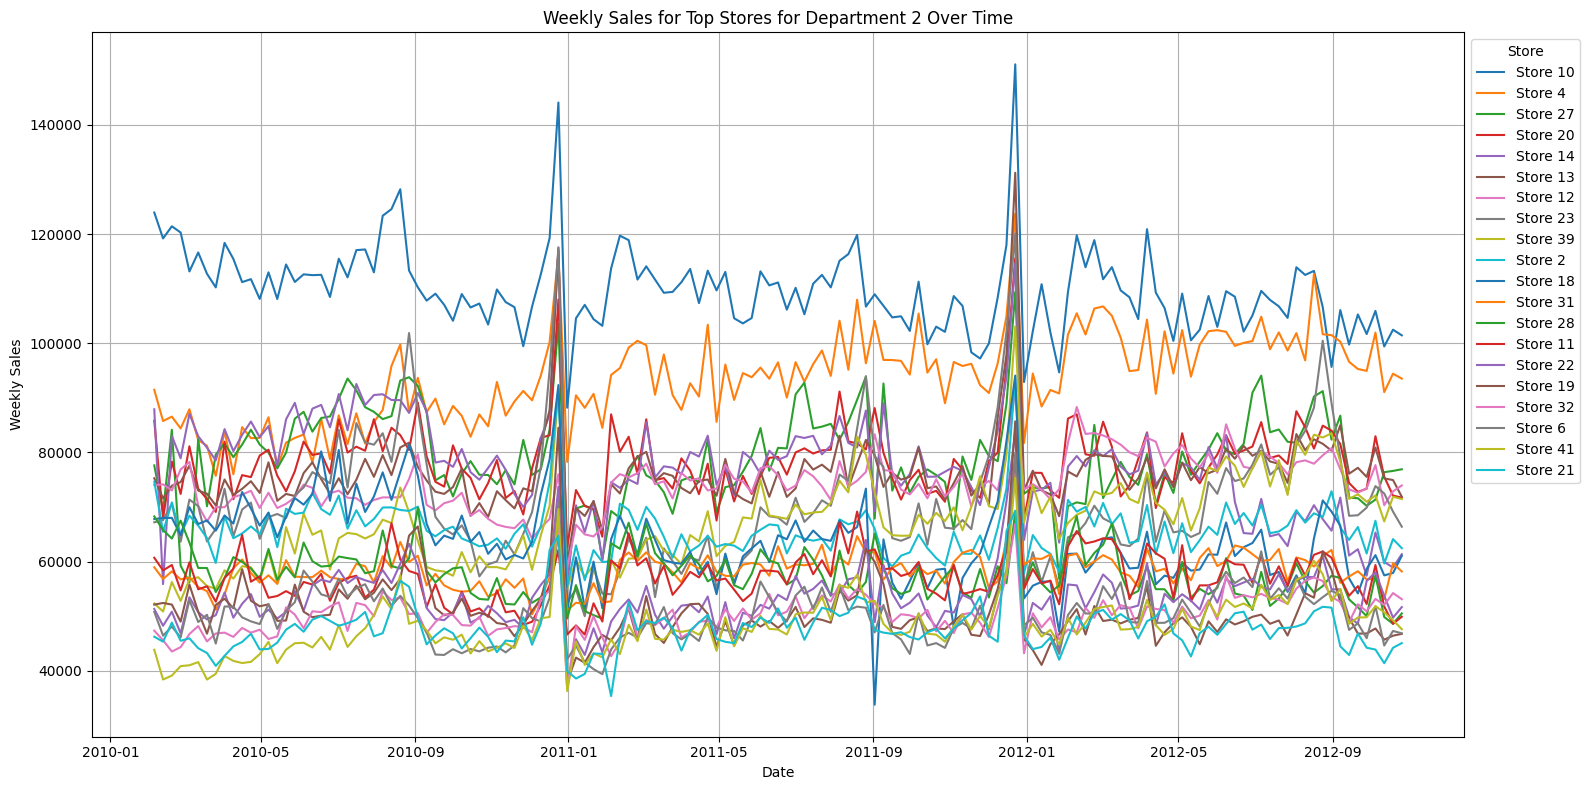

In [ ]:
# Choose a department ID
dept_id = 2  # You can change this to the department you are interested in

# Filter data for the selected department
dept_df = df[df['Dept'] == dept_id].copy()

# Group by Store and Date to get weekly sales for each store in the selected department
weekly_sales_by_store_dept = dept_df.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have Stores as columns and Dates as index
weekly_sales_pivot_store_dept = weekly_sales_by_store_dept.pivot(index='Date', columns='Store', values='Weekly_Sales').fillna(0)

# Get the total sales for each store across all weeks for this department to find the top stores
store_total_sales = weekly_sales_pivot_store_dept.sum().sort_values(ascending=False)

# Select the top 20 stores for this department (or all stores if less than 20)
top_stores_dept = store_total_sales.head(20).index

# Filter the pivoted data to include only the top stores
weekly_sales_pivot_store_dept_top_stores = weekly_sales_pivot_store_dept[top_stores_dept]

# Plot the weekly sales for the top stores in the selected department
plt.figure(figsize=(16, 8))

for store in weekly_sales_pivot_store_dept_top_stores.columns:
    plt.plot(weekly_sales_pivot_store_dept_top_stores.index, weekly_sales_pivot_store_dept_top_stores[store], label=f'Store {store}')

plt.title(f'Weekly Sales for Top Stores for Department {dept_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Split


In [94]:
# Model parameters
BACKCAST_LENGTH = 20
FORECAST_LENGTH = 40
BATCH_SIZE = 16
LR = 0.005
EPOCHS = 20
TRIALS = 50
FEATURES = ['Size', 'Dept']

PATCH_SIZE = 4

In [95]:
store_id = 9
dept_id = 9

df_sd = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)]

In [96]:
store_ids = [9, 10, 11, 12]
dept_ids = [9, 10, 11, 12]

df_sd = df[df['Store'].isin(store_ids) & df['Dept'].isin(dept_ids)]

In [97]:
df_sd = df

In [98]:
train_end_date = pd.to_datetime('2012-01-27')

df_train = df_sd[df_sd['Date'] < train_end_date]
df_val = df_sd[df_sd['Date'] >= train_end_date]

In [99]:
print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")

Training data shape: (303030, 16)
Validation data shape: (118540, 16)


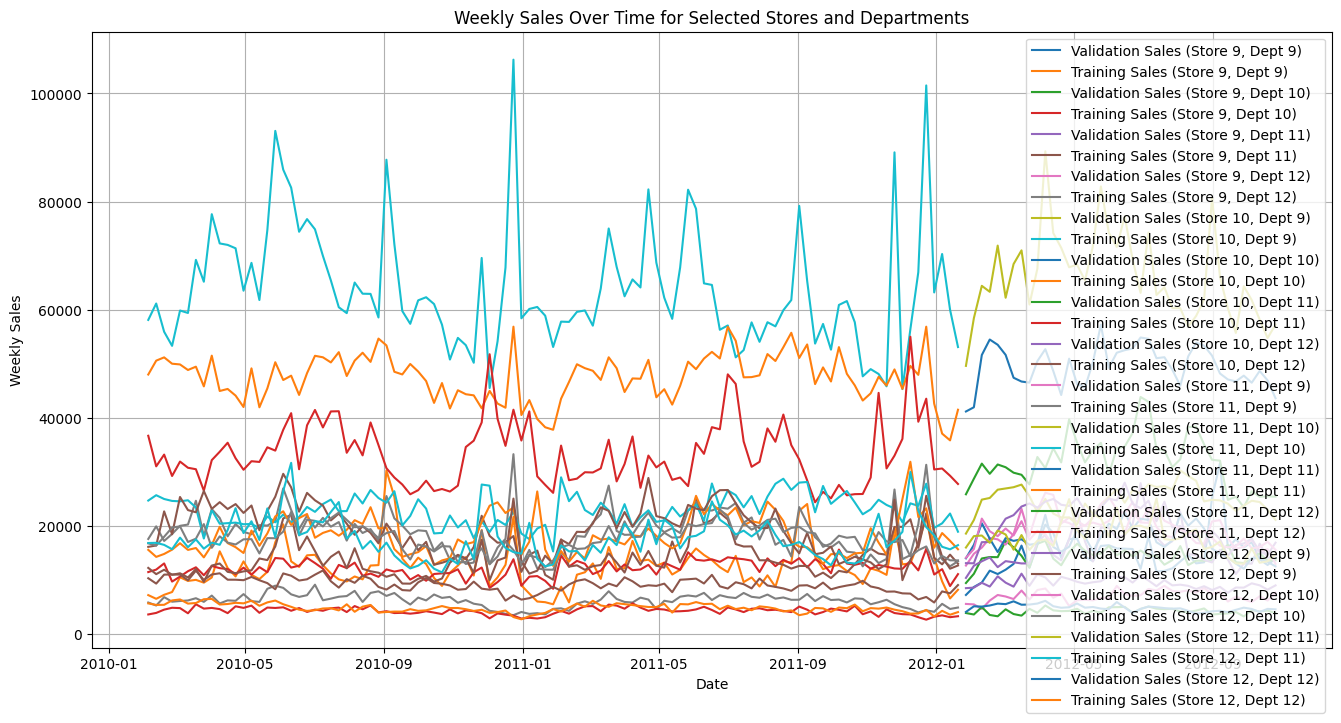

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Ensure store_ids and dept_ids are lists (they are defined as lists in i5pCl0_HAaGJ)
# store_ids = [9] # Example, these should come from your defined variables
# dept_ids = [9] # Example, these should come from your defined variables

for store_id in store_ids:
    for dept_id in dept_ids:
        # Filter data for the current store and department combination
        train_subset = df_train[(df_train['Store'] == store_id) & (df_train['Dept'] == dept_id)]
        val_subset = df_val[(df_val['Store'] == store_id) & (df_val['Dept'] == dept_id)]

        # Plot the training and validation sales
        plt.plot(val_subset['Date'],
                 val_subset['Weekly_Sales'],
                 label=f'Validation Sales (Store {store_id}, Dept {dept_id})')
        plt.plot(train_subset['Date'],
                 train_subset['Weekly_Sales'],
                 label=f'Training Sales (Store {store_id}, Dept {dept_id})')

plt.title('Weekly Sales Over Time for Selected Stores and Departments')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

# Transform Data to Fit

In [101]:
class SalesScaler(BaseEstimator, TransformerMixin):
    def __init__(self, target_column='Weekly_Sales'):
        self.target_column = target_column
        self.scaler = MinMaxScaler() # Or StandardScaler()

    def fit(self, X, y=None):
        # Fit on the target column
        self.scaler.fit(X[[self.target_column]])
        return self

    def transform(self, X):
        X = X.copy()
        # Transform the target column
        X[self.target_column] = self.scaler.transform(X[[self.target_column]])
        return X

    def inverse_transform(self, X_scaled):
        # Assuming X_scaled is the scaled data containing the target column
        # If only the scaled target is passed, adjust accordingly
        X_original = X_scaled.copy()
        X_original[self.target_column] = self.scaler.inverse_transform(X_scaled[[self.target_column]])
        return X_original

    def inverse_transform_array(self, array_scaled):
        # Use this if you have a numpy array or tensor of just the scaled target
        return self.scaler.inverse_transform(array_scaled.reshape(-1, 1))

    def transform_array(self, array_original):
        # Use this if you have a numpy array or tensor of just the original target
        return self.scaler.transform(array_original.reshape(-1, 1))


In [102]:
class FormatterPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocessor to:
    - Create 'unique_id' from Store and Dept
    - Rename columns for NeuralForecast (ds, y)
    - Keep only needed columns
    - Ensure datetime type for 'ds'
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        X = X.copy()
        # Create unique_id
        X['unique_id'] = X['Store'].astype(str) + '_' + X['Dept'].astype(str)
        # Rename columns
        X = X.rename(columns={
            'Weekly_Sales': 'y',
            'Date': 'ds'
        })
        # Keep only needed columns
        feats = ['unique_id', 'ds', 'y', 'IsHoliday_x']
        X = X[feats]
        # Ensure datetime type
        X['ds'] = pd.to_datetime(X['ds'])
        return X

In [103]:
preprocessor_pipeline = Pipeline([
    ('scaler', SalesScaler()),
    ('formatter', FormatterPreprocessor()),
])

# Apply the pipeline to your dataframes
formatted_train = preprocessor_pipeline.fit_transform(df_train.copy())
formatted_val = preprocessor_pipeline.transform(df_val.copy())

# Display the first few rows of the processed data
print("\nProcessed Training Data Head:")
display(formatted_train.head())

print("\nProcessed Validation Data Head:")
display(formatted_val.head())

print(f"\nProcessed Training data shape: {formatted_train.shape}")
print(f"Processed Validation data shape: {formatted_val.shape}")

# Store the scaler for inverse transformation later
sales_scaler = preprocessor_pipeline.named_steps['scaler']


Processed Training Data Head:


unique_id         ds         y  IsHoliday_x
0       1_1 2010-02-05  0.042851        False
1       1_1 2010-02-12  0.073097         True
2       1_1 2010-02-19  0.066732        False
3       1_1 2010-02-26  0.034942        False
4       1_1 2010-03-05  0.038415        False


Processed Validation Data Head:


unique_id         ds         y  IsHoliday_x
103       1_1 2012-01-27  0.033473        False
104       1_1 2012-02-03  0.040825        False
105       1_1 2012-02-10  0.060132         True
106       1_1 2012-02-17  0.084587        False
107       1_1 2012-02-24  0.035974        False


Processed Training data shape: (303030, 4)
Processed Validation data shape: (118540, 4)


# Train Model

In [104]:
from neuralforecast.losses.pytorch import MSE

from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import MSE
from neuralforecast.core import NeuralForecast

model = PatchTST(
    h=FORECAST_LENGTH,                # Forecast horizon
    input_size=48,  # Input window size
    patch_len=16,    # Patch length
    stride=16,          # Patch stride
    loss=MSE(),
    scaler_type='standard',
    max_steps=1000,
    dropout=0.1,           # ← Transformer dropout
    fc_dropout=0.1,     # ← Feedforward dropout
    head_dropout=0.1,  # ← Output head dropout
    n_heads=8,
    hidden_size = 512,
    linear_hidden_size = 512,
    activation = 'gelu',
    learning_rate=0.003
    )

nf = NeuralForecast(models=[model], freq='W-FRI')  # Weekly freq

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(model)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Model parameters: 4,826,664
PatchTST


In [105]:
nf.fit(df=formatted_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 4.8 M  | train
-----------------------------------------------------------
4.8 M     Trainable params
3         Non-trainable params
4.8 M     Total params
19.307    Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [106]:
preds = nf.predict(df=formatted_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Postprocessor

In [111]:
class SalesUnscaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        X = X.copy()
        X['y'] = self.scaler.inverse_transform_array(X['y'].values)
        X['PatchTST'] = self.scaler.inverse_transform_array(X['PatchTST'].values)
        return X

In [107]:
print(preds.head())
print(formatted_val.head())

  unique_id         ds  PatchTST
0      10_1 2012-01-27 -0.031209
1      10_1 2012-02-03  0.100110
2      10_1 2012-02-10  0.056400
3      10_1 2012-02-17  0.198757
4      10_1 2012-02-24 -0.039130
    unique_id         ds         y  IsHoliday_x
103       1_1 2012-01-27  0.033473        False
104       1_1 2012-02-03  0.040825        False
105       1_1 2012-02-10  0.060132         True
106       1_1 2012-02-17  0.084587        False
107       1_1 2012-02-24  0.035974        False


In [112]:
preds_combined = pd.merge(preds, formatted_val, on=['unique_id', 'ds'], how='left')
print(preds_combined.head())
preds_combined.shape

  unique_id         ds  PatchTST         y IsHoliday_x
0      10_1 2012-01-27 -0.031209  0.053787       False
1      10_1 2012-02-03  0.100110  0.059352       False
2      10_1 2012-02-10  0.056400  0.079393        True
3      10_1 2012-02-17  0.198757  0.114483       False
4      10_1 2012-02-24 -0.039130  0.048333       False


(132240, 5)

In [116]:
unscaler = SalesUnscaler(sales_scaler)

preds_combined_unscaled = unscaler.transform(preds_combined)

# Display the first few rows with unscaled columns
print(preds_combined_unscaled.head())

  unique_id         ds       PatchTST         y IsHoliday_x
0      10_1 2012-01-27  -26775.900391  32559.13       False
1      10_1 2012-02-03   64896.382812  36444.00       False
2      10_1 2012-02-10   34383.492188  50434.11        True
3      10_1 2012-02-17  133760.687500  74930.33       False
4      10_1 2012-02-24  -32305.095703  28751.57       False


In [117]:
# Calculate WMAE
wmae_score = WMAE(preds_combined_unscaled)

print(f"WMAE: {wmae_score}")

WMAE: 2589.1617753839846


In [123]:
def build(params):
    model = PatchTST(
        h=FORECAST_LENGTH,                # Forecast horizon
        input_size=params['input_size'],  # Input window size
        patch_len=params['patch_len'],    # Patch length
        stride=params['stride'],          # Patch stride
        loss=MSE(),
        scaler_type='standard',
        max_steps=params['max_steps'],
        dropout=params['dropout'],           # ← Transformer dropout
        fc_dropout=params['dropout'],     # ← Feedforward dropout
        head_dropout=params['dropout'],  # ← Output head dropout
        n_heads = params['n_heads'],
        hidden_size = params['d_model'],
        linear_hidden_size = params['d_ff'],
        activation = 'gelu',
        learning_rate=params['learning_rate']
        )

    nf = NeuralForecast(models=[model], freq='W-FRI')  # Weekly freq

    return nf

# Grid Search

In [ ]:
search_space = {
    # === ARCHITECTURE PARAMETERS ===
    'input_size': [48],  # Maps to embed_dim in PatchTST
    'dropout': [0.1],  # Dropout rate for transformer
    'max_steps': [500],
    'n_heads': [16],
    'd_model': [128],
    'd_ff': [256],
    'learning_rate': [0.001],

    # === PATCH CONFIGURATIONS (PatchTST specific) ===
    'patch_configs': [
        # === STANDARD CONFIGURATIONS ===
        {
            'patch_len': 16,
            'stride': 8,
            'description': 'Standard patching - 16/8'
        },
        {
            'patch_len': 12,
            'stride': 6,
            'description': 'Medium patching - 12/6'
        },
        {
            'patch_len': 8,
            'stride': 4,
            'description': 'Small patching - 8/4'
        },

        # === OVERLAPPING CONFIGURATIONS ===
        {
            'patch_len': 16,
            'stride': 4,
            'description': 'High overlap - 16/4'
        },
        {
            'patch_len': 12,
            'stride': 3,
            'description': 'Very high overlap - 12/3'
        },
        {
            'patch_len': 20,
            'stride': 5,
            'description': 'Large patch high overlap - 20/5'
        },

        # === NON-OVERLAPPING CONFIGURATIONS ===
        {
            'patch_len': 16,
            'stride': 16,
            'description': 'No overlap - 16/16'
        },
        {
            'patch_len': 12,
            'stride': 12,
            'description': 'No overlap - 12/12'
        },
        {
            'patch_len': 8,
            'stride': 8,
            'description': 'No overlap - 8/8'
        },

        # === LARGE PATCH CONFIGURATIONS ===
        {
            'patch_len': 24,
            'stride': 12,
            'description': 'Large patch - 24/12'
        },
        {
            'patch_len': 20,
            'stride': 10,
            'description': 'Large patch - 20/10'
        },
        {
            'patch_len': 28,
            'stride': 14,
            'description': 'Very large patch - 28/14'
        },

        # === SMALL PATCH CONFIGURATIONS ===
        {
            'patch_len': 6,
            'stride': 3,
            'description': 'Small patch - 6/3'
        },
        {
            'patch_len': 4,
            'stride': 2,
            'description': 'Very small patch - 4/2'
        },
        {
            'patch_len': 4,
            'stride': 1,
            'description': 'Tiny patch high overlap - 4/1'
        },

        # === SEASONAL CONFIGURATIONS ===
        {
            'patch_len': 7,
            'stride': 7,
            'description': 'Weekly seasonal - 7/7'
        },
        {
            'patch_len': 14,
            'stride': 7,
            'description': 'Bi-weekly overlap - 14/7'
        },
        {
            'patch_len': 26,
            'stride': 13,
            'description': 'Half-yearly - 26/13'
        },

        # === EXPERIMENTAL CONFIGURATIONS ===
        {
            'patch_len': 10,
            'stride': 5,
            'description': 'Decimal patching - 10/5'
        },
        {
            'patch_len': 15,
            'stride': 5,
            'description': 'Asymmetric overlap - 15/5'
        },
        {
            'patch_len': 18,
            'stride': 6,
            'description': 'Triple overlap - 18/6'
        },

        # === FINE-GRAINED CONFIGURATIONS ===
        {
            'patch_len': 6,
            'stride': 2,
            'description': 'Fine-grained - 6/2'
        },
        {
            'patch_len': 8,
            'stride': 2,
            'description': 'Fine-grained medium - 8/2'
        },
        {
            'patch_len': 10,
            'stride': 2,
            'description': 'Fine-grained large - 10/2'
        },

        # === BALANCED CONFIGURATIONS ===
        {
            'patch_len': 13,
            'stride': 7,
            'description': 'Balanced medium - 13/7'
        },
        {
            'patch_len': 17,
            'stride': 9,
            'description': 'Balanced large - 17/9'
        }
    ]
}

In [ ]:
import itertools
from typing import Dict, List, Any, Generator

def generate_parameter_combinations(search_space):
    """
    Generate all possible parameter combinations for PatchTST
    """
    patch_configs = search_space.get('patch_configs', [])
    other_params = {k: v for k, v in search_space.items() if k != 'patch_configs'}

    # Get all combinations of non-patch parameters
    param_names = list(other_params.keys())
    param_values = list(other_params.values())

    # Generate all combinations of regular parameters
    for param_combination in itertools.product(*param_values):
        base_params = dict(zip(param_names, param_combination))

        # For each patch configuration, yield a complete parameter set
        for patch_config in patch_configs:
            complete_params = base_params.copy()
            complete_params.update(patch_config)
            yield complete_params

In [ ]:
def grid_search_patchtst(search_space, device, file='patchtst_grid_search.txt'):
    """
    Perform grid search for PatchTST with proper discrete/continuous sampling
    """
    def print_b(txt, file):
        print(txt, file=file)
        print(txt)

    best_val_loss = float('inf')
    best_preds = None

    best_params = None
    best_model = None

    results = []

    with open(file, 'w') as f:
        combinations = generate_parameter_combinations(search_space)

        print_b(f"Starting PatchTST grid search...", file=f)
        print_b("Search space summary:", file=f)
        print_b(f"- Input Size: {search_space['input_size']}", file=f)
        print_b(f"- Dropout: {search_space['dropout']}", file=f)
        print_b(f"- Max Steps: {search_space['max_steps']}", file=f)
        print_b(f"- Learning Rate: {search_space['learning_rate']}", file=f)
        print_b(f"- Num Heads: {search_space['n_heads']}", file=f)
        print_b(f"- Dim Model: {search_space['d_model']}", file=f)
        print_b(f"- Dim FC: {search_space['d_ff']}", file=f)
        print_b(f"- Patch configurations: {len(search_space['patch_configs'])}", file=f)
        print_b("=" * 60, file=f)

        trial = 0
        for params in generate_parameter_combinations(search_space):
            # Sample hyperparameters
            print_b(f"Trial {trial + 1}", file=f)
            print_b(f"Patch Config: {params['description']}", file=f)
            print_b(f"Patch Length: {params['patch_len']}, Stride: {params['stride']}", file=f)
            print_b(f"Inp Size: {params['input_size']}, Dropout: {params['dropout']}", file=f)
            print_b(f"Num Heads: {params['n_heads']}, Dim Model: {params['d_model']}, Dim FC = {params['d_ff']}", file=f)
            print_b(f"Learning Rate: {params['learning_rate']}", file=f)

            num_patches = (BACKCAST_LENGTH - params['patch_len']) // params['stride'] + 1
            print_b(f"Number of patches: {num_patches}", file=f)

            nf = build(params)
            nf.fit(df=formatted_train)
            preds = nf.predict(df=formatted_train)
            preds_combined = pd.merge(preds, formatted_val, on=['unique_id', 'ds'], how='left')
            wmae_score = WMAE(preds_combined)

            print_b(f"Training Done! wmae score: {wmae_score:.6f}", file=f)
            print_b('-' * 40, file=f)

            if wmae_score < best_val_loss:
                best_val_loss = wmae_score
                best_preds = preds_combined
                best_params = params
                best_model = model
                print_b(f"New best WMAE: {best_val_loss:.6f}", file=f)

            results.append((params, wmae_score))

            trial += 1

        # Sort results by validation loss
        results.sort(key=lambda x: x[1])

        # Print final summary
        print_b("\n" + "=" * 60, file=f)
        print_b("FINAL RESULTS SUMMARY", file=f)
        print_b("=" * 60, file=f)
        print_b(f"Total trials: {trial}", file=f)
        print_b(f"Best WMAE: {best_val_loss:.6f}", file=f)
        print_b(f"Best configuration:", file=f)
        if best_params:
            for key, value in best_params.items():
                print_b(f"  {key}: {value}", file=f)

        print_b("\nTop 5 configurations:", file=f)
        for i, (params, score) in enumerate(results[:5]):
            print_b(f"Rank {i+1}: WMAE = {score:.6f}", file=f)
            print_b(f"  Config: {params.get('description', 'N/A')}", file=f)
            print_b(f"  Patch: {params.get('patch_len', 'N/A')}/{params.get('stride', 'N/A')}", file=f)
            print_b(f"  Input Size: {params.get('input_size', 'N/A')}, Dropout: {params.get('dropout', 'N/A')}", file=f)
            print_b(f"  Num Heads: {params.get('n_heads', 'N/A')}, Dim Model: {params.get('d_model', 'N/A')}, Dim FC: {params.get('d_ff', 'N/A')}", file=f)
            print_b(f"  Learning Rate: {params.get('learning_rate', 'N/A')}", file=f)

    return best_params, best_preds, best_val_loss, best_model, results

In [ ]:
best_params, best_preds, best_val_loss, best_model, results = grid_search_patchtst(search_space, device)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 431 K  | train
-----------------------------------------------------------
431 K     Trainable params
3         Non-trainable params
431 K     Total params
1.725     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Starting PatchTST grid search...
Search space summary:
- Input Size: [48]
- Dropout: [0.1]
- Max Steps: [500]
- Learning Rate: [0.001]
- Num Heads: [16]
- Dim Model: [128]
- Dim FC: [256]
- Patch configurations: 26
Trial 1
Patch Config: Standard patching - 16/8
Patch Length: 16, Stride: 8
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 441 K  | train
-----------------------------------------------------------
441 K     Trainable params
3         Non-trainable params
441 K     Total params
1.765     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2355.860239
----------------------------------------
New best WMAE: 2355.860239
Trial 2
Patch Config: Medium patching - 12/6
Patch Length: 12, Stride: 6
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 461 K  | train
-----------------------------------------------------------
461 K     Trainable params
3         Non-trainable params
461 K     Total params
1.846     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2375.955060
----------------------------------------
Trial 3
Patch Config: Small patching - 8/4
Patch Length: 8, Stride: 4
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 4


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Done! wmae score: 2440.211551
----------------------------------------
Trial 4
Patch Config: High overlap - 16/4
Patch Length: 16, Stride: 4
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 452 K  | train
-----------------------------------------------------------
452 K     Trainable params
3         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 472 K  | train
-----------------------------------------------------------
472 K     Trainable params
3         Non-trainable params
472 K     Total params
1.890     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2385.057112
----------------------------------------
Trial 5
Patch Config: Very high overlap - 12/3
Patch Length: 12, Stride: 3
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 436 K  | train
-----------------------------------------------------------
436 K     Trainable params
3         Non-trainable params
436 K     Total params
1.748     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2445.070855
----------------------------------------
Trial 6
Patch Config: Large patch high overlap - 20/5
Patch Length: 20, Stride: 5
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 420 K  | train
-----------------------------------------------------------
420 K     Trainable params
3         Non-trainable params
420 K     Total params
1.683     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2414.658388
----------------------------------------
Trial 7
Patch Config: No overlap - 16/16
Patch Length: 16, Stride: 16
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 425 K  | train
-----------------------------------------------------------
425 K     Trainable params
3         Non-trainable params
425 K     Total params
1.702     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2239.793033
----------------------------------------
New best WMAE: 2239.793033
Trial 8
Patch Config: No overlap - 12/12
Patch Length: 12, Stride: 12
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 435 K  | train
-----------------------------------------------------------
435 K     Trainable params
3         Non-trainable params
435 K     Total params
1.741     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2451.433908
----------------------------------------
Trial 9
Patch Config: No overlap - 8/8
Patch Length: 8, Stride: 8
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 421 K  | train
-----------------------------------------------------------
421 K     Trainable params
3         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2574.245673
----------------------------------------
Trial 10
Patch Config: Large patch - 24/12
Patch Length: 24, Stride: 12
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 421 K  | train
-----------------------------------------------------------
421 K     Trainable params
3         Non-trainable params
421 K     Total params
1.685     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2414.949872
----------------------------------------
Trial 11
Patch Config: Large patch - 20/10
Patch Length: 20, Stride: 10
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 416 K  | train
-----------------------------------------------------------
416 K     Trainable params
3         Non-trainable params
416 K     Total params
1.668     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2481.871742
----------------------------------------
Trial 12
Patch Config: Very large patch - 28/14
Patch Length: 28, Stride: 14
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 482 K  | train
-----------------------------------------------------------
482 K     Trainable params
3         Non-trainable params
482 K     Total params
1.929     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2275.620895
----------------------------------------
Trial 13
Patch Config: Small patch - 6/3
Patch Length: 6, Stride: 3
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 524 K  | train
-----------------------------------------------------------
524 K     Trainable params
3         Non-trainable params
524 K     Total params
2.096     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2444.449358
----------------------------------------
Trial 14
Patch Config: Very small patch - 4/2
Patch Length: 4, Stride: 2
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 639 K  | train
-----------------------------------------------------------
639 K     Trainable params
3         Non-trainable params
639 K     Total params
2.558     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2279.717453
----------------------------------------
Trial 15
Patch Config: Tiny patch high overlap - 4/1
Patch Length: 4, Stride: 1
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 17


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 435 K  | train
-----------------------------------------------------------
435 K     Trainable params
3         Non-trainable params
435 K     Total params
1.741     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2476.443612
----------------------------------------
Trial 16
Patch Config: Weekly seasonal - 7/7
Patch Length: 7, Stride: 7
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 430 K  | train
-----------------------------------------------------------
430 K     Trainable params
3         Non-trainable params
430 K     Total params
1.724     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2419.269905
----------------------------------------
Trial 17
Patch Config: Bi-weekly overlap - 14/7
Patch Length: 14, Stride: 7
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 416 K  | train
-----------------------------------------------------------
416 K     Trainable params
3         Non-trainable params
416 K     Total params
1.667     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2239.626780
----------------------------------------
New best WMAE: 2239.626780
Trial 18
Patch Config: Half-yearly - 26/13
Patch Length: 26, Stride: 13
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Done! wmae score: 2319.296581
----------------------------------------
Trial 19
Patch Config: Decimal patching - 10/5
Patch Length: 10, Stride: 5
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 3


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 446 K  | train
-----------------------------------------------------------
446 K     Trainable params
3         Non-trainable params
446 K     Total params
1.784     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 441 K  | train
-----------------------------------------------------------
441 K     Trainable params
3         Non-trainable params
441 K     Total params
1.766     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2438.471493
----------------------------------------
Trial 20
Patch Config: Asymmetric overlap - 15/5
Patch Length: 15, Stride: 5
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 436 K  | train
-----------------------------------------------------------
436 K     Trainable params
3         Non-trainable params
436 K     Total params
1.747     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2450.569072
----------------------------------------
Trial 21
Patch Config: Triple overlap - 18/6
Patch Length: 18, Stride: 6
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 519 K  | train
-----------------------------------------------------------
519 K     Trainable params
3         Non-trainable params
519 K     Total params
2.076     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2345.108285
----------------------------------------
Trial 22
Patch Config: Fine-grained - 6/2
Patch Length: 6, Stride: 2
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 8


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Training Done! wmae score: 2366.415494
----------------------------------------
Trial 23
Patch Config: Fine-grained medium - 8/2
Patch Length: 8, Stride: 2
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 7


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 514 K  | train
-----------------------------------------------------------
514 K     Trainable params
3         Non-trainable params
514 K     Total params
2.056     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Training Done! wmae score: 2373.124099
----------------------------------------
Trial 24
Patch Config: Fine-grained large - 10/2
Patch Length: 10, Stride: 2
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 509 K  | train
-----------------------------------------------------------
509 K     Trainable params
3         Non-trainable params
509 K     Total params
2.036     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 436 K  | train
-----------------------------------------------------------
436 K     Trainable params
3         Non-trainable params
436 K     Total params
1.744     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in 

Training Done! wmae score: 2418.726751
----------------------------------------
Trial 25
Patch Config: Balanced medium - 13/7
Patch Length: 13, Stride: 7
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Done! wmae score: 2389.100837
----------------------------------------
Trial 26
Patch Config: Balanced large - 17/9
Patch Length: 17, Stride: 9
Inp Size: 48, Dropout: 0.1
Num Heads: 16, Dim Model: 128, Dim FC = 256
Learning Rate: 0.001
Number of patches: 1


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 426 K  | train
-----------------------------------------------------------
426 K     Trainable params
3         Non-trainable params
426 K     Total params
1.704     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Training Done! wmae score: 2212.142582
----------------------------------------
New best WMAE: 2212.142582

FINAL RESULTS SUMMARY
Total trials: 26
Best WMAE: 2212.142582
Best configuration:
  input_size: 48
  dropout: 0.1
  max_steps: 500
  n_heads: 16
  d_model: 128
  d_ff: 256
  learning_rate: 0.001
  patch_len: 17
  stride: 9
  description: Balanced large - 17/9

Top 5 configurations:
Rank 1: WMAE = 2212.142582
  Config: Balanced large - 17/9
  Patch: 17/9
  Input Size: 48, Dropout: 0.1
  Num Heads: 16, Dim Model: 128, Dim FC: 256
  Learning Rate: 0.001
Rank 2: WMAE = 2239.626780
  Config: Bi-weekly overlap - 14/7
  Patch: 14/7
  Input Size: 48, Dropout: 0.1
  Num Heads: 16, Dim Model: 128, Dim FC: 256
  Learning Rate: 0.001
Rank 3: WMAE = 2239.793033
  Config: No overlap - 16/16
  Patch: 16/16
  Input Size: 48, Dropout: 0.1
  Num Heads: 16, Dim Model: 128, Dim FC: 256
  Learning Rate: 0.001
Rank 4: WMAE = 2275.620895
  Config: Very large patch - 28/14
  Patch: 28/14
  Input Size: 4

In [ ]:
torch.save(best_model.state_dict(), 'model.pth')

# Random Search

In [ ]:
TRIALS = 50

search_space = {
    # DISCRETE - Architecture parameters
    'input_size': [48, 96],               # Lookback window size
    'dropout': [0.1, 0.2, 0.3],               # Dropout rate (Transformer + Feedforward + Head)
    'max_steps': [500],                       # Max training steps (early stopping often kicks in before this)
    'n_heads': [4, 8, 16],                     # Attention heads (more heads → more expressiveness, higher compute)
    'd_model': [128, 256, 512],               # Hidden dimension (embed size)
    'd_ff': [256, 512, 1024],

    # CONTINUOUS - Learning parameters
    'learning_rate': {
        'type': 'log_uniform',
        'low': 1e-4,
        'high': 1e-2
    },

    # DISCRETE - Patch configurations
    'patch_configs': [
        {
            'patch_len': 16,
            'stride': 8,
            'description': 'Standard patching - 16/8'
        },
        {
            'patch_len': 16,
            'stride': 16,
            'description': 'No overlap - 16/16'
        },
        {
            'patch_len': 28,
            'stride': 14,
            'description': 'Very large patch - 28/14'
        },
        {
            'patch_len': 14,
            'stride': 7,
            'description': 'Bi-weekly overlap - 14/7'
        },
        {
            'patch_len': 17,
            'stride': 9,
            'description': 'Balanced large - 17/9'
        }
    ]
}

In [124]:
TRIALS = 1

search_space = {
    # DISCRETE - Architecture parameters
    'input_size': [48],               # Lookback window size
    'dropout': [0.1],               # Dropout rate (Transformer + Feedforward + Head)
    'max_steps': [1000],                       # Max training steps (early stopping often kicks in before this)
    'n_heads': [8],                     # Attention heads (more heads → more expressiveness, higher compute)
    'd_model': [512],               # Hidden dimension (embed size)
    'd_ff': [512],

    # CONTINUOUS - Learning parameters
    'learning_rate': {
        'type': 'log_uniform',
        'low': 0.003,
        'high': 0.003
    },

    # DISCRETE - Patch configurations
    'patch_configs': [
        {
            'patch_len': 16,
            'stride': 16,
            'description': 'No overlap - 16/16'
        }
    ]
}

In [125]:
def sample_hyperparameters(search_space):
    """
    Sample hyperparameters with appropriate discrete/continuous handling
    """
    params = {}

    # Sample discrete parameters
    params['input_size'] = random.choice(search_space['input_size'])
    params['max_steps'] = random.choice(search_space['max_steps'])
    params['n_heads'] = random.choice(search_space['n_heads'])
    params['d_model'] = random.choice(search_space['d_model'])
    params['d_ff'] = random.choice(search_space['d_ff'])
    params['dropout'] = random.choice(search_space['dropout'])

    # Sample continuous parameters (log-uniform for learning rate)
    lr_config = search_space['learning_rate']
    params['learning_rate'] = np.exp(np.random.uniform(
        np.log(lr_config['low']),
        np.log(lr_config['high'])
    ))

    # Sample stack configuration
    stack_config = random.choice(search_space['patch_configs'])
    params['patch_len'] = stack_config['patch_len']
    params['stride'] = stack_config['stride']
    params['description'] = stack_config['description']

    return params

In [132]:
def random_search_patchtst(search_space, device, n_trials=TRIALS, file='patchtst_random_search.txt'):
    """
    Perform random search for PatchTST with proper discrete/continuous sampling
    """
    def print_b(txt, file):
        print(txt, file=file)
        print(txt)

    best_val_loss = float('inf')
    best_preds = None

    best_params = None
    best_model = None

    results = []

    with open(file, 'w') as f:
        print_b(f"Starting PatchTST random search with {n_trials} trials...", file=f)
        print_b("Search space summary:", file=f)
        print_b(f"- Input Size: {search_space['input_size']}", file=f)
        print_b(f"- Dropout: {search_space['dropout']}", file=f)
        print_b(f"- Max Steps: {search_space['max_steps']}", file=f)
        print_b(f"- Learning Rate: {search_space['learning_rate']}", file=f)
        print_b(f"- Num Heads: {search_space['n_heads']}", file=f)
        print_b(f"- Dim Model: {search_space['d_model']}", file=f)
        print_b(f"- Dim FC: {search_space['d_ff']}", file=f)
        print_b(f"- Patch configurations: {len(search_space['patch_configs'])}", file=f)
        print_b("=" * 60, file=f)

        for trial in range(n_trials):
            # Sample hyperparameters
            random.seed(trial)
            np.random.seed(trial)
            params = sample_hyperparameters(search_space)

            print_b(f"Trial {trial + 1}/{n_trials}", file=f)
            print_b(f"Patch Config: {params['description']}", file=f)
            print_b(f"Patch Length: {params['patch_len']}, Stride: {params['stride']}", file=f)
            print_b(f"Inp Size: {params['input_size']}, Dropout: {params['dropout']}", file=f)
            print_b(f"Num Heads: {params['n_heads']}, Dim Model: {params['d_model']}, Dim FC = {params['d_ff']}", file=f)
            print_b(f"Learning Rate: {params['learning_rate']}", file=f)

            num_patches = (BACKCAST_LENGTH - params['patch_len']) // params['stride'] + 1
            print_b(f"Number of patches: {num_patches}", file=f)

            nf = build(params)
            nf.fit(df=formatted_train)
            preds = nf.predict(df=formatted_train)
            preds_combined = pd.merge(preds, formatted_val, on=['unique_id', 'ds'], how='left')
            preds_combined_unscaled = unscaler.transform(preds_combined)
            wmae_score = WMAE(preds_combined_unscaled)

            print_b(f"Training Done! wmae score: {wmae_score:.6f}", file=f)
            print_b('-' * 40, file=f)

            if wmae_score < best_val_loss:
                best_val_loss = wmae_score
                best_preds = preds_combined_unscaled
                best_params = params
                best_model = nf
                print_b(f"New best WMAE: {best_val_loss:.6f}", file=f)

            results.append((params, wmae_score))

        # Sort results by validation loss
        results.sort(key=lambda x: x[1])

        # Print final summary
        print_b("\n" + "=" * 60, file=f)
        print_b("FINAL RESULTS SUMMARY", file=f)
        print_b("=" * 60, file=f)
        print_b(f"Total trials: {n_trials}", file=f)
        print_b(f"Best WMAE: {best_val_loss:.6f}", file=f)
        print_b(f"Best configuration:", file=f)
        if best_params:
            for key, value in best_params.items():
                print_b(f"  {key}: {value}", file=f)

        print_b("\nTop 5 configurations:", file=f)
        for i, (params, score) in enumerate(results[:5]):
            print_b(f"Rank {i+1}: WMAE = {score:.6f}", file=f)
            print_b(f"  Config: {params.get('description', 'N/A')}", file=f)
            print_b(f"  Patch: {params.get('patch_len', 'N/A')}/{params.get('stride', 'N/A')}", file=f)
            print_b(f"  Input Size: {params.get('input_size', 'N/A')}, Dropout: {params.get('dropout', 'N/A')}", file=f)
            print_b(f"  Num Heads: {params.get('n_heads', 'N/A')}, Dim Model: {params.get('d_model', 'N/A')}, Dim FC: {params.get('d_ff', 'N/A')}", file=f)
            print_b(f"  Learning Rate: {params.get('learning_rate', 'N/A')}", file=f)

    return best_params, best_preds, best_val_loss, best_model, results

In [133]:
best_params, best_preds, best_val_loss, best_model, results = random_search_patchtst(search_space, device)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Starting PatchTST random search with 1 trials...
Search space summary:
- Input Size: [48]
- Dropout: [0.1]
- Max Steps: [500]
- Learning Rate: {'type': 'log_uniform', 'low': 0.003, 'high': 0.003}
- Num Heads: [8]
- Dim Model: [512]
- Dim FC: [512]
- Patch configurations: 1
Trial 1/1
Patch Config: No overlap - 16/16
Patch Length: 16, Stride: 16
Inp Size: 48, Dropout: 0.1
Num Heads: 8, Dim Model: 512, Dim FC = 512
Learning Rate: 0.002999999999999999
Number of patches: 1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MSE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 4.8 M  | train
-----------------------------------------------------------
4.8 M     Trainable params
3         Non-trainable params
4.8 M     Total params
19.307    Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Training Done! wmae score: 3074.133283
----------------------------------------
New best WMAE: 3074.133283

FINAL RESULTS SUMMARY
Total trials: 1
Best WMAE: 3074.133283
Best configuration:
  input_size: 48
  max_steps: 500
  n_heads: 8
  d_model: 512
  d_ff: 512
  dropout: 0.1
  learning_rate: 0.002999999999999999
  patch_len: 16
  stride: 16
  description: No overlap - 16/16

Top 5 configurations:
Rank 1: WMAE = 3074.133283
  Config: No overlap - 16/16
  Patch: 16/16
  Input Size: 48, Dropout: 0.1
  Num Heads: 8, Dim Model: 512, Dim FC: 512
  Learning Rate: 0.002999999999999999


In [134]:
best_model.predict(df=formatted_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds  PatchTST
0           10_1 2012-01-27  0.010821
1           10_1 2012-02-03  0.059320
2           10_1 2012-02-10  0.070880
3           10_1 2012-02-17  0.200247
4           10_1 2012-02-24 -0.040960
...          ...        ...       ...
132235      9_98 2012-09-14  0.007362
132236      9_98 2012-09-21  0.007494
132237      9_98 2012-09-28  0.007182
132238      9_98 2012-10-05  0.007790
132239      9_98 2012-10-12  0.007031

[132240 rows x 3 columns]

In [136]:
!rm -r patchtst_model

In [137]:
best_model.save(path='patchtst_model')

In [138]:
loaded = NeuralForecast.load(path='patchtst_model')

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [139]:
loaded.predict(df=formatted_train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id         ds  PatchTST
0           10_1 2012-01-27  0.010821
1           10_1 2012-02-03  0.059320
2           10_1 2012-02-10  0.070880
3           10_1 2012-02-17  0.200247
4           10_1 2012-02-24 -0.040960
...          ...        ...       ...
132235      9_98 2012-09-14  0.007362
132236      9_98 2012-09-21  0.007494
132237      9_98 2012-09-28  0.007182
132238      9_98 2012-10-05  0.007790
132239      9_98 2012-10-12  0.007031

[132240 rows x 3 columns]

# Prediction

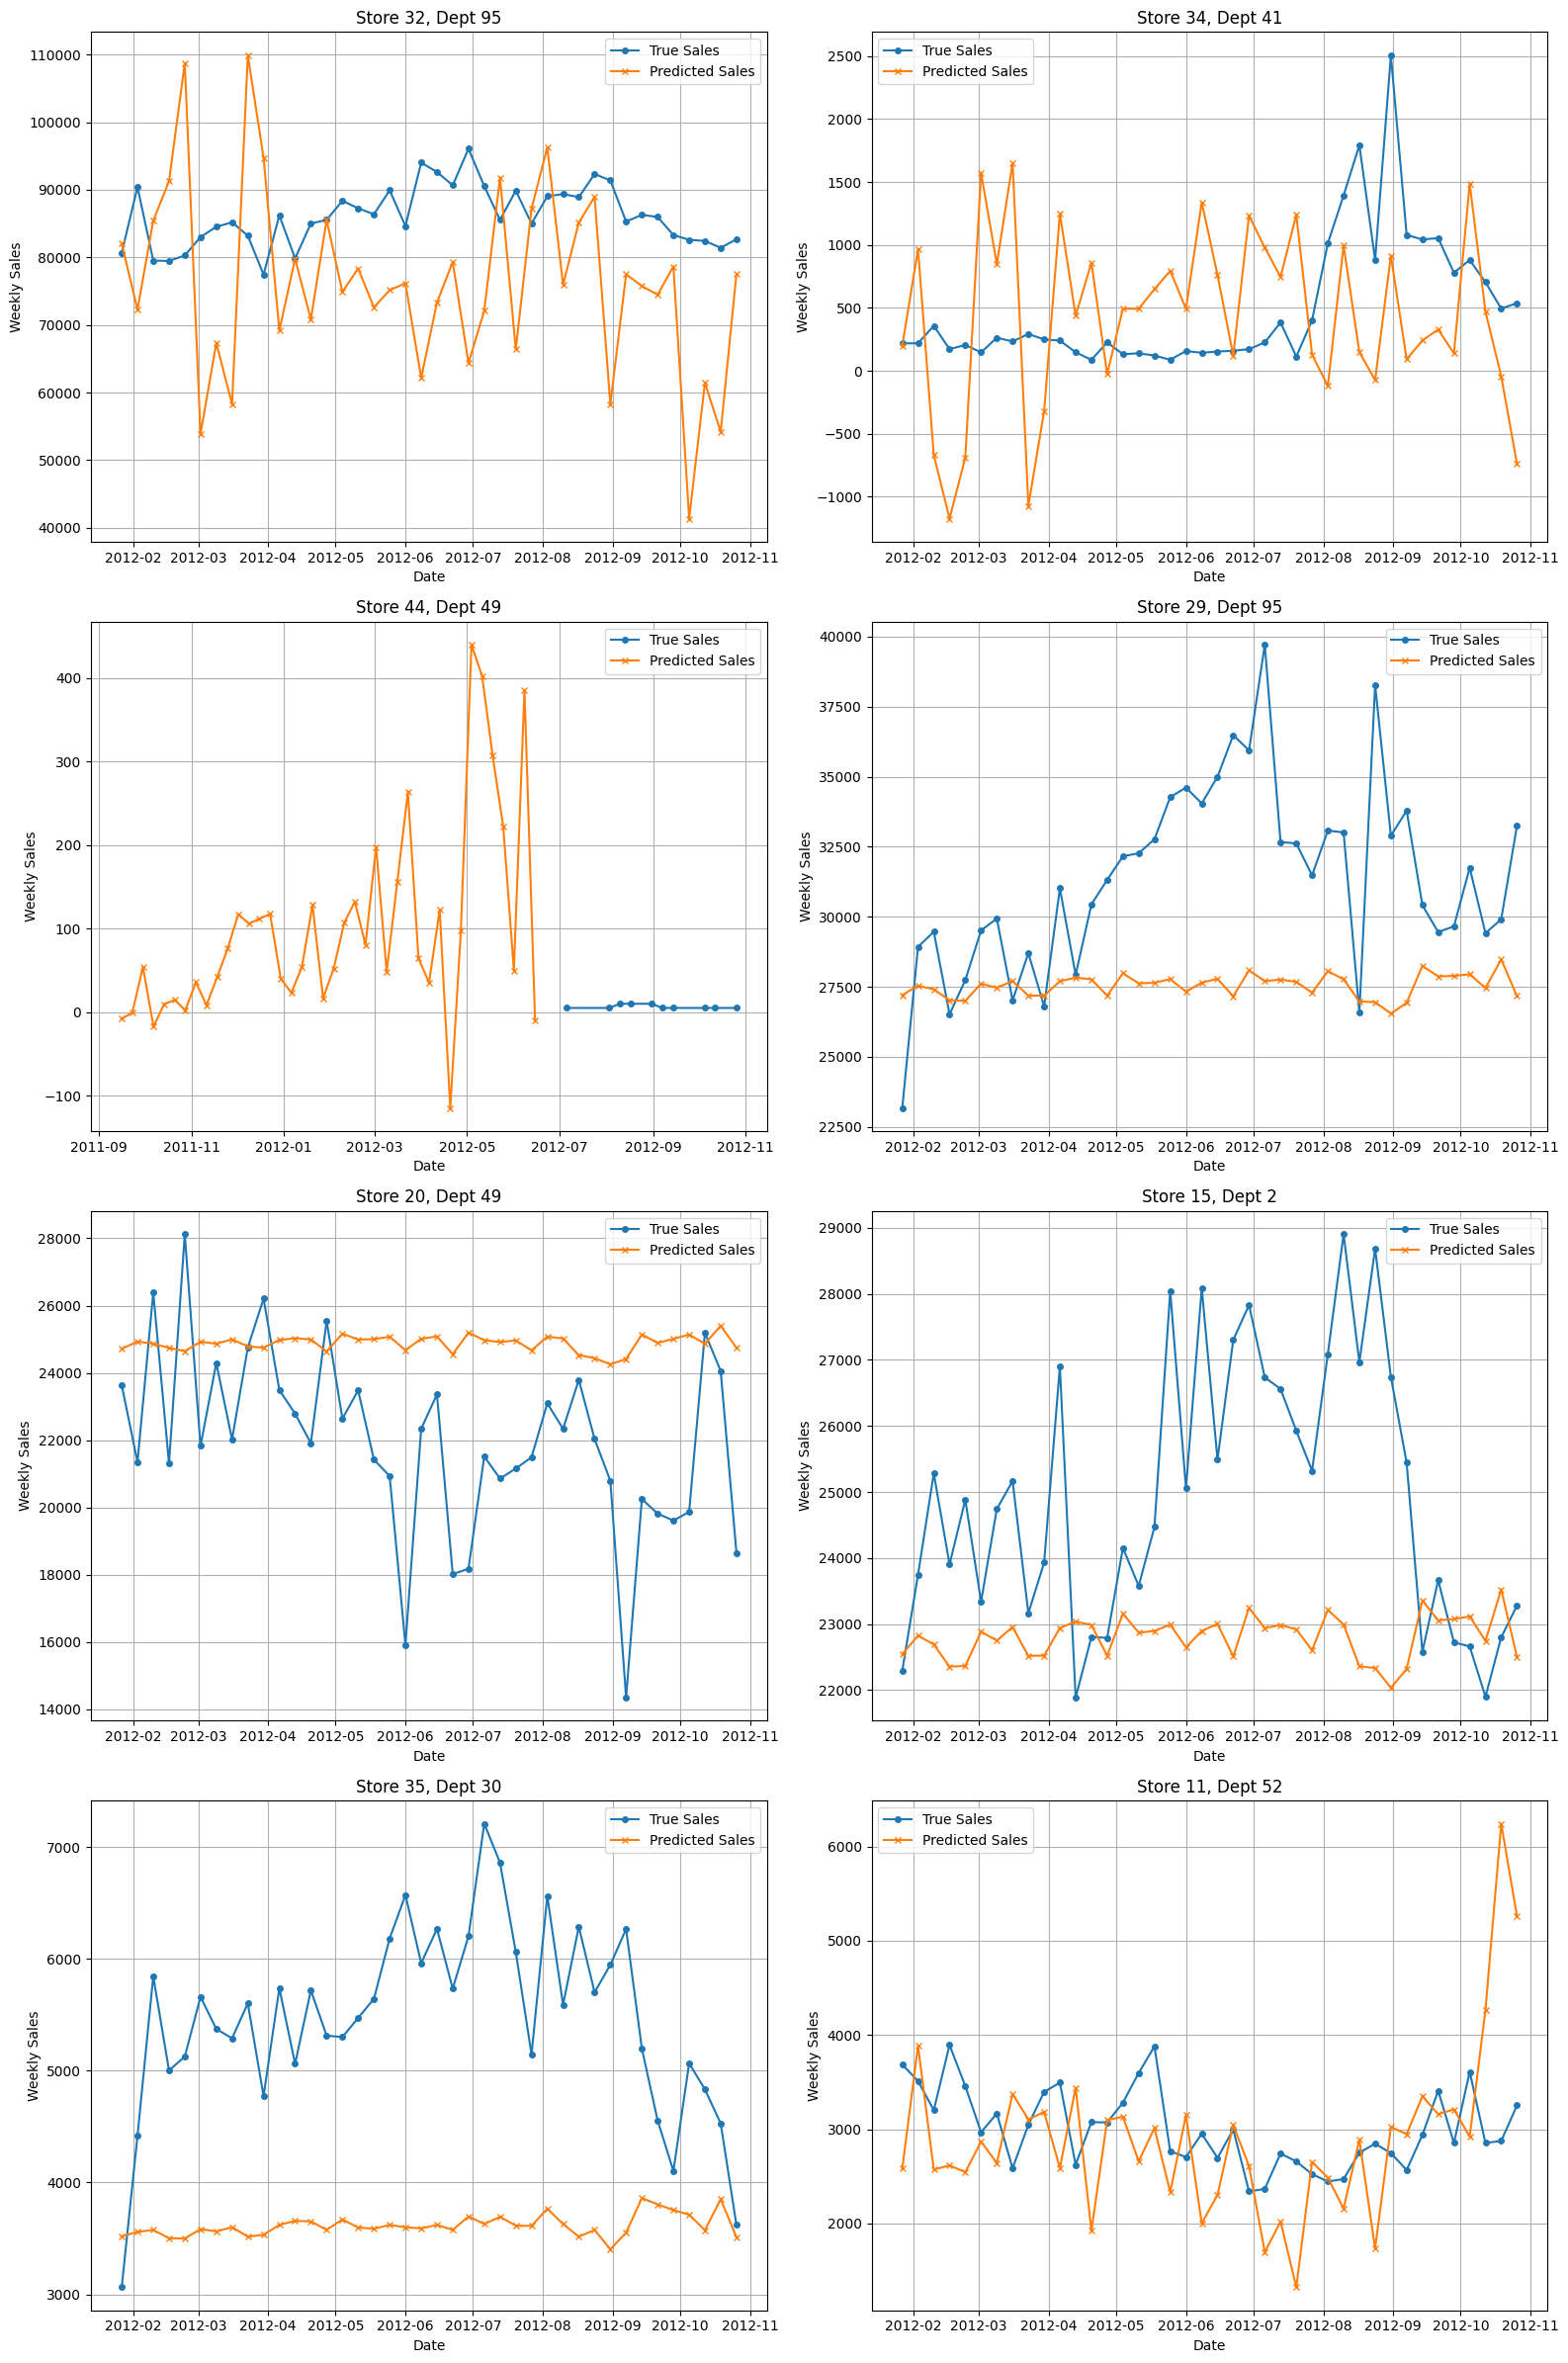

In [145]:
# Group true values by unique_id and sort by date
formatted_val['PatchTST'] = formatted_val['y']
unscaled = unscaler.transform(formatted_val)
true_grouped = unscaled.groupby('unique_id').apply(lambda x: x.sort_values('ds')).reset_index(drop=True)

# Group predictions by unique_id and sort by date
preds_grouped = best_preds.groupby('unique_id').apply(lambda x: x.sort_values('ds')).reset_index(drop=True)

unique_ids = true_grouped['unique_id'].unique()
n_unique_ids = len(unique_ids)

# Select a random sample of 8 unique_ids, or all if there are fewer than 8
sample_size = min(8, n_unique_ids)
random_unique_ids = random.sample(list(unique_ids), sample_size)

# Determine the number of rows and columns for the subplots
n_cols = 2  # You can adjust the number of columns
n_rows = (sample_size + n_cols - 1) // n_cols # Calculate necessary rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, unique_id in enumerate(random_unique_ids):
    ax = axes[i] # Get the current subplot axis

    true_subset = true_grouped[true_grouped['unique_id'] == unique_id]
    preds_subset = preds_grouped[preds_grouped['unique_id'] == unique_id]

    ax.plot(true_subset['ds'], true_subset['y'], label=f'True Sales', marker='o', markersize=4)
    ax.plot(preds_subset['ds'], preds_subset['PatchTST'], label=f'Predicted Sales', marker='x', markersize=4)

    ax.set_title(f'Store {unique_id.split("_")[0]}, Dept {unique_id.split("_")[1]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(sample_size, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('predictions.png') # Corrected function name
plt.show()

In [147]:
print(best_val_loss)

3074.133282639351


WMAE for the best PatchTST model: 3074.133282639351


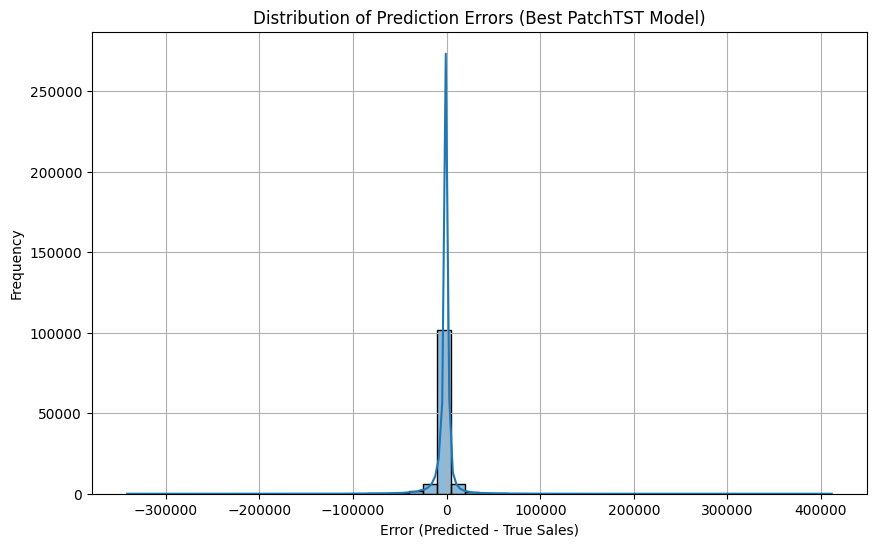

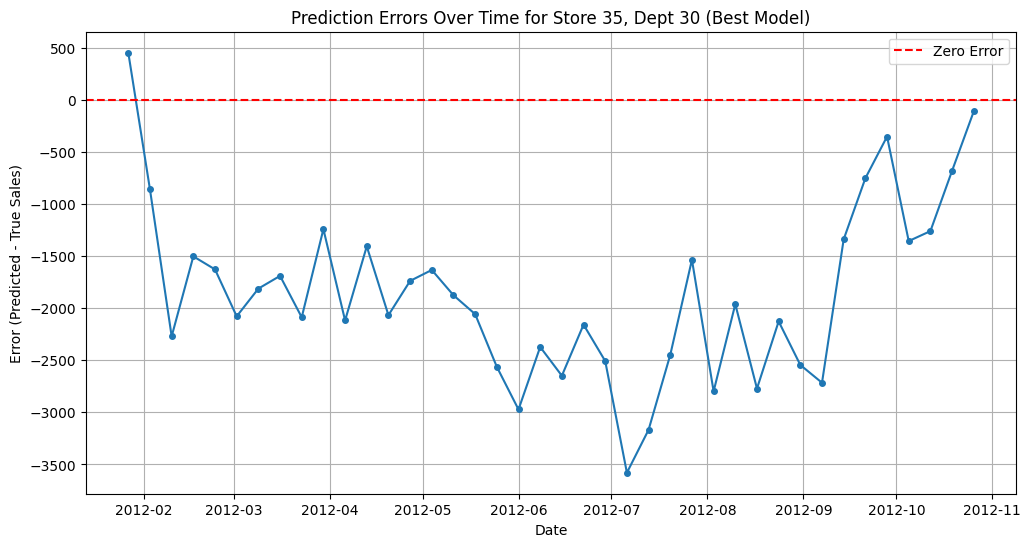

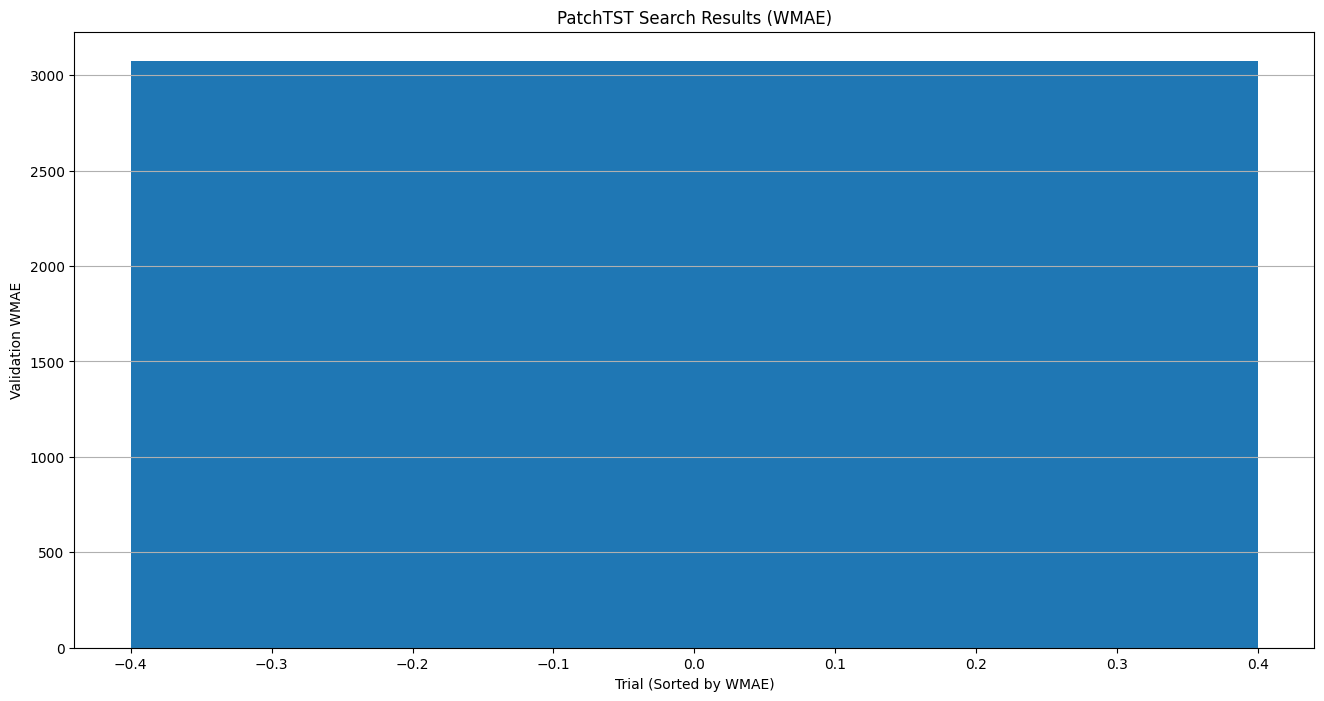

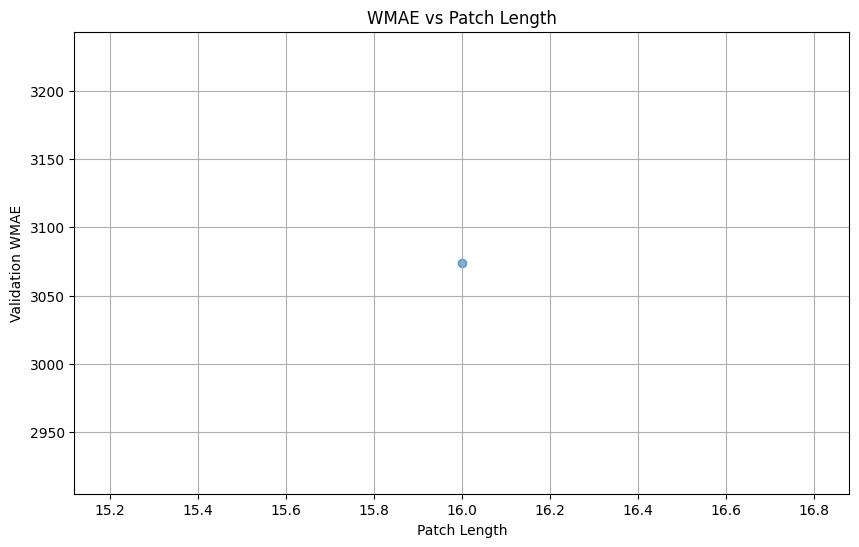

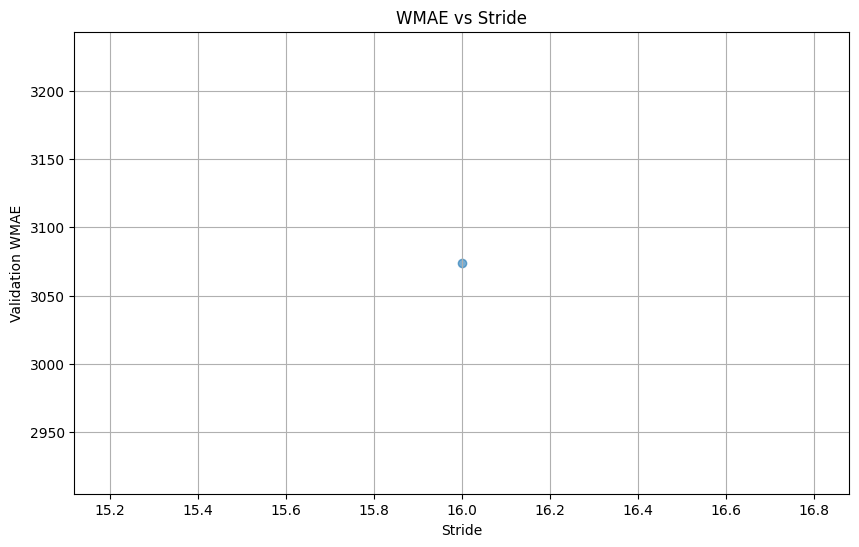

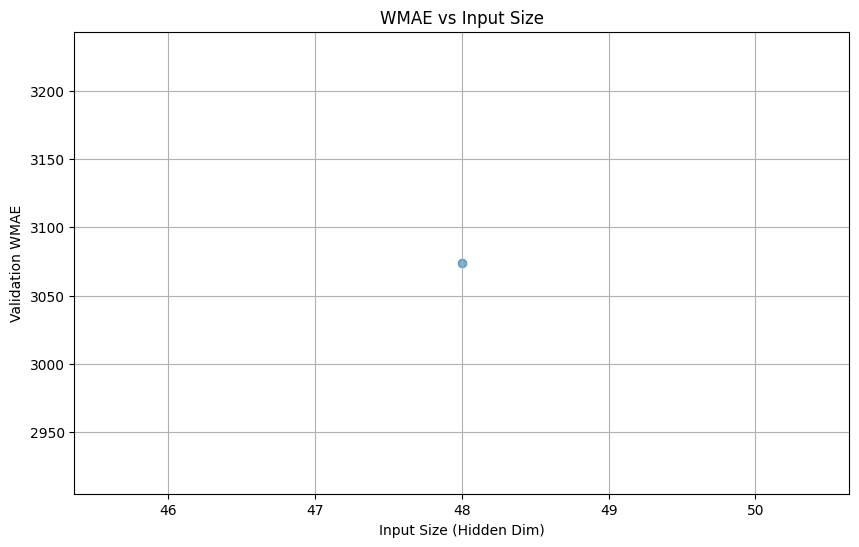

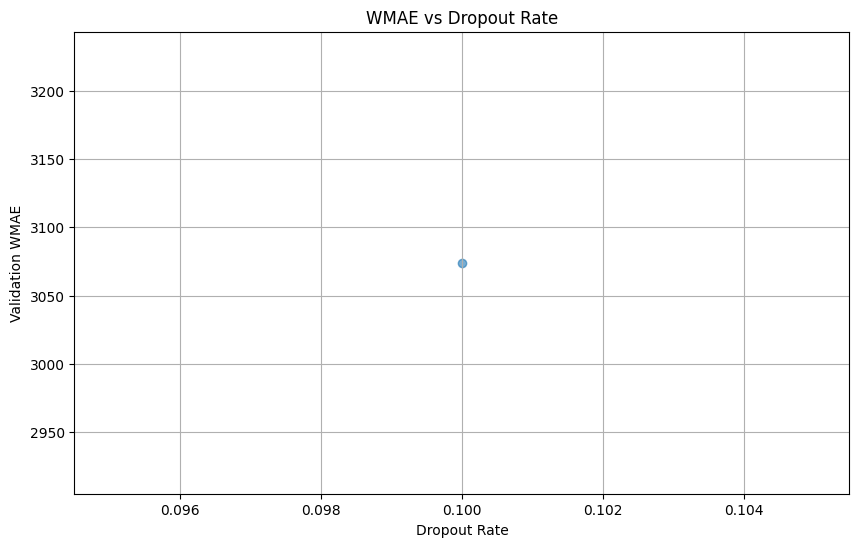

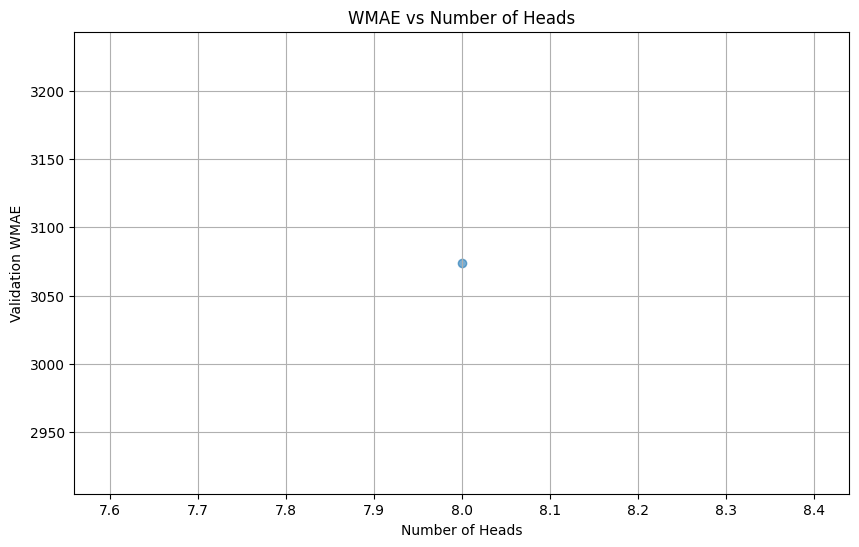

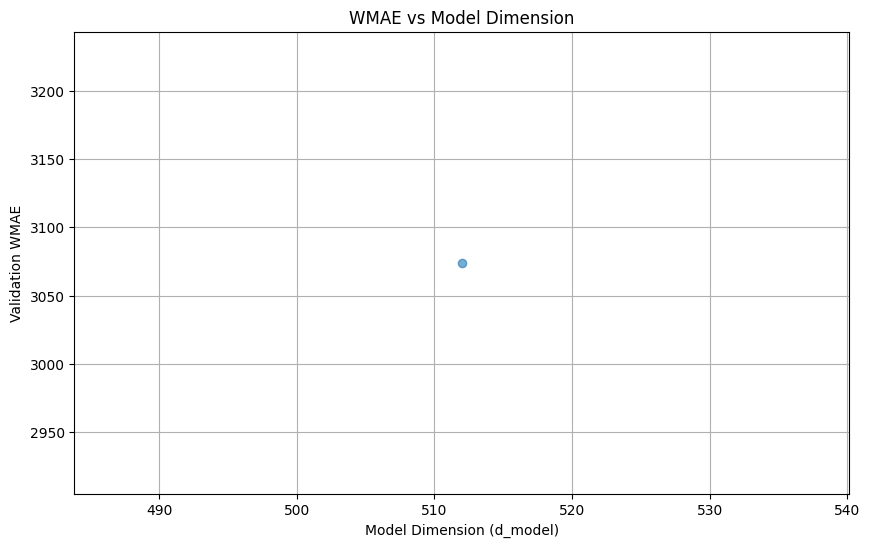

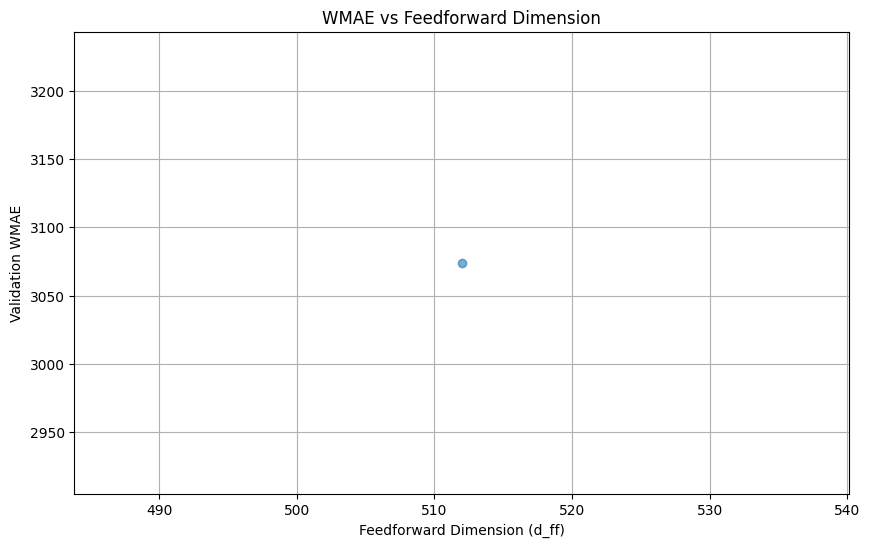

In [148]:
import matplotlib.pyplot as plt
# Assuming `best_preds` and `formatted_val` DataFrames are available from previous code
# Assuming `WMAE` function is also available

# Calculate WMAE on the best model's predictions
best_wmae_score = WMAE(best_preds)

print(f"WMAE for the best PatchTST model: {best_wmae_score}")

# You can also visualize the distribution of errors
best_preds['error'] = best_preds['PatchTST'] - best_preds['y']

plt.figure(figsize=(10, 6))
sns.histplot(best_preds['error'].dropna(), bins=50, kde=True)
plt.title('Distribution of Prediction Errors (Best PatchTST Model)')
plt.xlabel('Error (Predicted - True Sales)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('errors_freq.png')
plt.show()

# Visualize errors over time for a sample unique_id
sample_unique_id_for_error = random.choice(random_unique_ids) # Use one of the sampled IDs
error_subset = best_preds[best_preds['unique_id'] == sample_unique_id_for_error].dropna(subset=['error'])

plt.figure(figsize=(12, 6))
plt.plot(error_subset['ds'], error_subset['error'], marker='o', linestyle='-', markersize=4)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title(f'Prediction Errors Over Time for Store {sample_unique_id_for_error.split("_")[0]}, Dept {sample_unique_id_for_error.split("_")[1]} (Best Model)')
plt.xlabel('Date')
plt.ylabel('Error (Predicted - True Sales)')
plt.legend()
plt.grid(True)
plt.savefig('errors.png')
plt.show()

# If you saved the results from the random search, you can visualize the WMAE scores
# This part assumes 'results' variable from the grid search is still available
if 'results' in locals() and results:
    # Extract WMAE scores and parameters
    wmae_scores = [score for params, score in results]
    configs = [f"P:{p['patch_len']} S:{p['stride']}" for p, score in results] # Simplified config label

    # Sort by WMAE for better visualization
    sorted_results = sorted(results, key=lambda x: x[1])
    sorted_wmae_scores = [score for params, score in sorted_results]
    sorted_configs = [f"P:{p['patch_len']} S:{p['stride']} Inp:{p['input_size']}" for p, score in sorted_results]

    plt.figure(figsize=(16, 8))
    plt.bar(range(len(sorted_wmae_scores)), sorted_wmae_scores)
    plt.ylabel('Validation WMAE')
    plt.xlabel('Trial (Sorted by WMAE)')
    plt.title('PatchTST Search Results (WMAE)')
    plt.grid(axis='y')
    plt.savefig('search_results.png')
    plt.show()

    # Scatter plot of patch_len vs WMAE
    patch_lens = [p['patch_len'] for p, score in results if 'patch_len' in p]
    strides = [p['stride'] for p, score in results if 'stride' in p]
    input_sizes = [p['input_size'] for p, score in results if 'input_size' in p]
    dropouts = [p['dropout'] for p, score in results if 'dropout' in p]
    n_heads_list = [p['n_heads'] for p, score in results if 'n_heads' in p]
    d_model_list = [p['d_model'] for p, score in results if 'd_model' in p]
    d_ff_list = [p['d_ff'] for p, score in results if 'd_ff' in p]

    # Ensure lists are not empty before plotting
    if patch_lens:
        plt.figure(figsize=(10, 6))
        plt.scatter(patch_lens, wmae_scores, alpha=0.6)
        plt.xlabel('Patch Length')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Patch Length')
        plt.grid(True)
        plt.savefig('patch_length.png')
        plt.show()

    if strides:
        plt.figure(figsize=(10, 6))
        plt.scatter(strides, wmae_scores, alpha=0.6)
        plt.xlabel('Stride')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Stride')
        plt.grid(True)
        plt.savefig('stride.png')
        plt.show()

    if input_sizes:
        plt.figure(figsize=(10, 6))
        plt.scatter(input_sizes, wmae_scores, alpha=0.6)
        plt.xlabel('Input Size (Hidden Dim)')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Input Size')
        plt.grid(True)
        plt.savefig('input_size.png')
        plt.show()

    if dropouts:
        plt.figure(figsize=(10, 6))
        plt.scatter(dropouts, wmae_scores, alpha=0.6)
        plt.xlabel('Dropout Rate')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Dropout Rate')
        plt.grid(True)
        plt.savefig('dropout.png')
        plt.show()

    # Add scatter plot for n_heads vs WMAE
    if n_heads_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(n_heads_list, wmae_scores, alpha=0.6)
        plt.xlabel('Number of Heads')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Number of Heads')
        plt.grid(True)
        plt.savefig('n_heads.png')
        plt.show()

    # Add scatter plot for d_model vs WMAE
    if d_model_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(d_model_list, wmae_scores, alpha=0.6)
        plt.xlabel('Model Dimension (d_model)')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Model Dimension')
        plt.grid(True)
        plt.savefig('d_model.png')
        plt.show()

    # Add scatter plot for d_ff vs WMAE
    if d_ff_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(d_ff_list, wmae_scores, alpha=0.6)
        plt.xlabel('Feedforward Dimension (d_ff)')
        plt.ylabel('Validation WMAE')
        plt.title('WMAE vs Feedforward Dimension')
        plt.grid(True)
        plt.savefig('d_ff.png')
        plt.show()

# Test Saving

In [152]:
preprocessor_pipeline_filename = 'preprocessor_pipeline.pkl'
with open(preprocessor_pipeline_filename, 'wb') as f:
    pickle.dump(preprocessor_pipeline, f)

print(f"Preprocessor pipeline saved to {preprocessor_pipeline_filename}")

with open(preprocessor_pipeline_filename, 'rb') as f:
    loaded_preprocessor_pipeline = pickle.load(f)

print(f"Preprocessor pipeline loaded from {preprocessor_pipeline_filename}")

formatted_train_loaded = loaded_preprocessor_pipeline.transform(df_train.copy())
print("\nTransformed data using loaded pipeline (head):")
display(formatted_train_loaded.head())



Preprocessor pipeline saved to preprocessor_pipeline.pkl
Preprocessor pipeline loaded from preprocessor_pipeline.pkl

Transformed data using loaded pipeline (head):


unique_id         ds         y  IsHoliday_x
0       1_1 2010-02-05  0.042851        False
1       1_1 2010-02-12  0.073097         True
2       1_1 2010-02-19  0.066732        False
3       1_1 2010-02-26  0.034942        False
4       1_1 2010-03-05  0.038415        False

# Start MLFlow

In [149]:
!pip install dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [150]:
import dagshub
import mlflow
from mlflow.models.signature import infer_signature
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=ee4b1c6a-3a69-4b80-bf84-239924ae28bb&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=80c707479d59335cfa8c85fb9856e6a6be9c8b0346f766652a2651626b8afa23




Accessing as Cimbir

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [151]:
mlflow.set_experiment('PatchTST_Training')

<Experiment: artifact_location='mlflow-artifacts:/b332dccb413846a9ae9cccfec228e18b', creation_time=1751629748407, experiment_id='5', last_update_time=1751629748407, lifecycle_stage='active', name='PatchTST_Training', tags={}>

In [153]:
with mlflow.start_run(run_name=f'PatchTST_Model_preprocessing') as run:
  pickle.dump(preprocessor_pipeline, open('preprocessor.pkl', 'wb'))
  mlflow.log_artifact('preprocessor.pkl')

🏃 View run PatchTST_Model_preprocessing at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5/runs/6ccd85f8892c44d4ae42fdb0bd2fcf06
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5


In [154]:
with mlflow.start_run(run_name=f'PatchTST_Model_postprocessing') as run:
  pickle.dump(unscaler, open('postprocessor.pkl', 'wb'))
  mlflow.log_artifact('postprocessor.pkl')

🏃 View run PatchTST_Model_postprocessing at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5/runs/236506472a064d85adfa83a5ae3919b8
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5


In [155]:
with mlflow.start_run(run_name=f'PatchTST_Model_Best') as run:
  mlflow.log_param('search_method', 'random')
  mlflow.log_param('search_space', search_space)
  mlflow.log_param('best_params', best_params)
  mlflow.log_param('forecast', FORECAST_LENGTH)
  mlflow.log_param('trials', TRIALS)

  mlflow.log_metric('best_wmae', best_val_loss)

  mlflow.log_text(str(best_model), 'model_summary.txt')

  mlflow.log_artifact('predictions.png')
  mlflow.log_artifact('dropout.png')
  mlflow.log_artifact('errors.png')
  mlflow.log_artifact('errors_freq.png')
  mlflow.log_artifact('input_size.png')
  mlflow.log_artifact('patch_length.png')
  mlflow.log_artifact('search_results.png')
  mlflow.log_artifact('stride.png')
  mlflow.log_artifact('patchtst_random_search.txt')
  mlflow.log_artifact('n_heads.png')
  mlflow.log_artifact('d_model.png')
  mlflow.log_artifact('d_ff.png')

  # Log the entire model directory
  mlflow.log_artifacts('patchtst_model', artifact_path='model')

🏃 View run PatchTST_Model_Best at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5/runs/37c3db63b1444338afa6b41de0dd84df
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/5


# Start WandB

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

In [ ]:
def wandb_run():
    with wandb.init(
        project='walmart-recruiting-sales-N-BEATS',
        name='PATCHTST'):
      torch.save(best_model.state_dict(), 'model.pt')
      wandb.save('model.pt')  # upload to W&B

wandb_run()